In [1]:
! pip3 install POT

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance as wd
import ot
import torch
from torch import nn, optim

rng = np.random.seed(0)
size = 7;
cm = 0.393701; #inches
markers = ["o", "s", "<", ">", "d", "+"]

In [3]:
from numpy.random import default_rng

rng = default_rng()

def find_OT_collision_nd_nmargins_new(x, Total_Cost, Change_Cost, MinIter=20, MaxIter=100000, tol = 1e-3, avg_window=20, ISvectorized=True):
    # x with size (Nmargins, N, dim)
    N_m = x.shape[0] # number of margins
    N_p = x.shape[1] # number of samples per margin
    tries = N_p
    sum_ = 1000000
    ids = np.array([[i for i in range(N_p)] for j in range(N_m)]) # Nmargines, Np

    dists_coll = [Total_Cost(x)]

    Jt = [np.mean(x[0,:,:]*x[1,:,:])]
    for nt in range(1, MaxIter+1):
        for k in range(N_m):
            iss = rng.choice(Np, size=tries, replace=False)
            i1s = iss[:int(tries/2)]
            i2s = iss[int(tries/2):]

            if ISvectorized is True:
              s0 = Change_Cost(x, ids, i1s, i2s, k, before=True)
              s1 = Change_Cost(x, ids, i1s, i2s, k, before=False)

              # Determine which swaps to accept
              mask = s1 < s0

              # Perform the swaps for accepted cases
              accepted_i1s = i1s[mask]
              accepted_i2s = i2s[mask]

              x[k,accepted_i1s,:], x[k,accepted_i2s,:] = x[k,accepted_i2s,:].copy(), x[k,accepted_i1s,:].copy()
            else:
              for jj in range(int(Np/2)):
                #print("-- test")
                s0 = Change_Cost(x, ids, i1s, i2s, k, before=True)[0]
                s1 = Change_Cost(x, ids, i1s, i2s, k, id_m=[jj], before=False)[0]
                if s1 < s0:
                  #print("-- accept")
                  temp = x[k, i1s[jj], :].copy()
                  x[k, i1s[jj], :] = x[k, i2s[jj], :].copy()
                  x[k, i2s[jj], :] = temp.copy()
                  #snew = Change_Cost(x, ids, i1s, i2s, k, before=True, ISvectorized=False)[0]
                  #print("s0:", s0, "s1:", s1, "snew", snew)


        cost = Total_Cost(x)
        dists_coll.append( cost )
        Jt.append( np.mean(x[0,:,:]*x[1,:,:]) )

        if nt>avg_window and nt > MinIter:
            sum_0 = np.sum(np.array(dists_coll)[-avg_window:])
            if abs(sum_ - sum_0)/sum_0 < tol:
              break
            sum_ = sum_0


    return x, ids, dists_coll, nt, np.array(Jt)

def total_cost(x_m):
  Nm_m = x_m.shape[0]
  Np_m = x_m.shape[1]
  y = 0.0
  for i in range(Nm_m):
    for j in range(i+1, Nm_m):
        y += np.sum( np.sum( (x_m[i, :, :]-x_m[j, :, :])**2 , axis=1) )
  return y/Np_m

def change_cost(x_m, ids_m, i1s_m, i2s_m, k_m, before=True):
  Nm_m = x_m.shape[0]
  s_m = np.ones(len(i1s_m))
  for j_m in range(Nm_m):
    if j_m != k_m:
        #s_m += np.sum( np.sum( (x_m[j_m,ids_m[j_m,:],:]-x_m[k_m,ids_m[k_m,:],:])**2, axis=1) )
        s_m += np.sum( np.sum( (x_m[j_m,:,:]-x_m[k_m,:,:])**2, axis=1) )

        if before is False:
          #s_m -= np.sum( (x_m[j_m,ids_m[j_m,i1s_m],:]-x_m[k_m,ids_m[k_m,i1s_m],:])**2, axis=1)
          #s_m -= np.sum( (x_m[j_m,ids_m[j_m,i2s_m],:]-x_m[k_m,ids_m[k_m,i2s_m],:])**2, axis=1)
          #s_m += np.sum( (x_m[j_m,ids_m[j_m,i1s_m],:]-x_m[k_m,ids_m[k_m,i2s_m],:])**2, axis=1)
          #s_m += np.sum( (x_m[j_m,ids_m[j_m,i2s_m],:]-x_m[k_m,ids_m[k_m,i1s_m],:])**2, axis=1)

          s_m -= np.sum( (x_m[j_m,i1s_m,:]-x_m[k_m,i1s_m,:])**2, axis=1)
          s_m -= np.sum( (x_m[j_m,i2s_m,:]-x_m[k_m,i2s_m,:])**2, axis=1)
          s_m += np.sum( (x_m[j_m,i1s_m,:]-x_m[k_m,i2s_m,:])**2, axis=1)
          s_m += np.sum( (x_m[j_m,i2s_m,:]-x_m[k_m,i1s_m,:])**2, axis=1)

  return s_m

# Generate a data set

In [50]:
def sigma(t,j):
  return 1. #np.sin(2*j*t*np.pi)

def forward(X, dt):
    for j in range(X.shape[0]):
        X[j,:] = X[j,:] - ( X[j,:]-np.mean(X[j,:]) )*dt + (2*dt)**0.5 * np.random.normal(0,1,(Np))
        # #X[j,:] += -0.5*( sigma(t, j) + np.matmul(corr[j,:],X) ) * dt + eta[j] * sigma(t, j) * (dt)**0.5 * np.random.normal(0,1,(Np))
    return X
def generate_data(Np, N = 10, Nt = 100, every=20, dt = 0.1, **kwargs):
  eta = kwargs.get('eta')
  corr = kwargs.get('corr')

  X = np.zeros((N,Np))
  for j in range(N):
    for i in range(Np):
      mu = np.random.uniform(-2,2)
      sd = 1./np.random.gamma(3.,1.)
      X[j,i] = np.random.normal(mu, sd)
  data = [X.copy()]
  for i in range(1, Nt):
      t = i*dt
      X = forward(X, dt)
      for j in range(X.shape[0]):
        np.random.shuffle(X[j,:])
      if i%every==0 :
        data.append(X.copy())
  data = np.swapaxes(data,1,2)
  return data

#generate data
np.random.seed(0)
Np = 10000 # number of samples per variable
N = 5 # number of r.v. dim(X)
Nt = 2 # number of steps, number of marginals
every = 1

eta = np.random.normal(0,1,(N))
corr = np.random.normal(0,1,(N,N))

variables_dict = {
    'eta': eta,
    'corr': corr
}

Xt = generate_data(Np=Np, N=N, Nt=Nt, every=every, **variables_dict)

Xt0 = Xt.copy()
print(Xt.shape)

(2, 10000, 5)


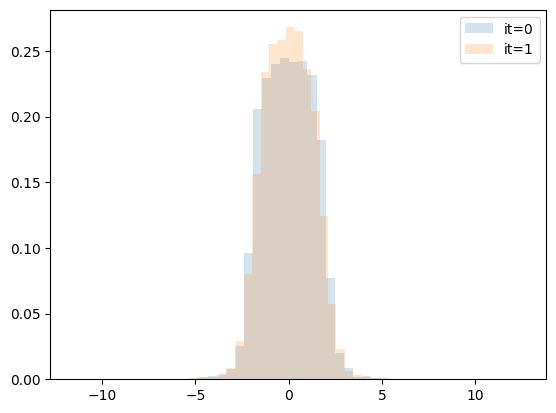

In [51]:
plt.figure()
#it = 1
#[plt.hist(Xt[it,:,dim],bins=50,alpha=0.2, label="N="+str(dim), density=True) for dim in range(N)]
dim=0
[plt.hist(Xt[it,:,dim],bins=50,alpha=0.2, label="it="+str(it),density=True) for it in range(0,Xt.shape[0])]

plt.legend()

In [60]:
Y = np.random.normal(0,1, Xt[0:1,...].shape)

XX = np.concatenate([Y, Xt[0:1,...], Xt[1:2,...]],axis=0)
XX0 = XX.copy()
print(XX.shape)

(3, 10000, 5)


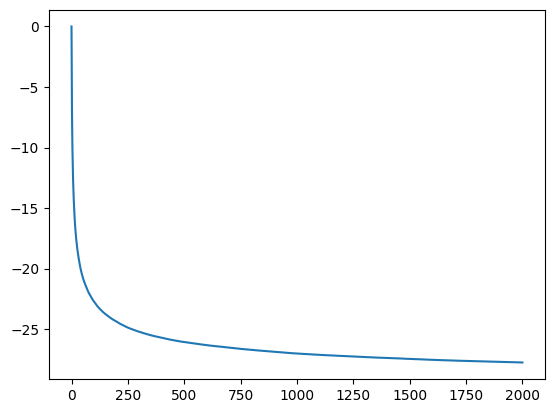

In [61]:
from lib.collision_wrapper import find_OT_collision as newot

XX = XX0.copy()
XX, dists_coll, nt = newot(XX, MinIter=2000, MaxIter=2000, tol = 1e-9, avg_window=20, Track=0, bi=1)
plt.plot(dists_coll)

In [65]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, Nm, n, hidden_dim=50):
        super(Model, self).__init__()
        self.n = n
        self.Nm = Nm
        self.fc = nn.Sequential(
            nn.Linear(Nm*n, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, n)
        )

    def forward(self, x): # x: Nm, Np, n
        Np = x.shape[1]
        x = x.permute(1,0,2) # Np, Nm, n
        x = x.reshape(x.shape[0],x.shape[1]*x.shape[2]) # Np, Nm*n

        x = self.fc(x) # y: Np, 1*n
        x = x.reshape(x.shape[0], 1, self.n) # Np, 1, n
        x = x.permute(1,0,2) # 1, Np, n
        return x
    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        loss = torch.mean(torch.sum((self.forward(X) - Y) ** 2, dim=1))
        return loss


Epoch 100, Loss: 3331.131591796875
Epoch 200, Loss: 3061.873779296875
Epoch 300, Loss: 2932.327392578125
Epoch 400, Loss: 2833.417724609375
Epoch 500, Loss: 2761.307861328125
Epoch 600, Loss: 2720.917724609375
Epoch 700, Loss: 2701.8466796875
Epoch 800, Loss: 2688.7451171875
Epoch 900, Loss: 2677.08544921875
Epoch 1000, Loss: 2665.831298828125


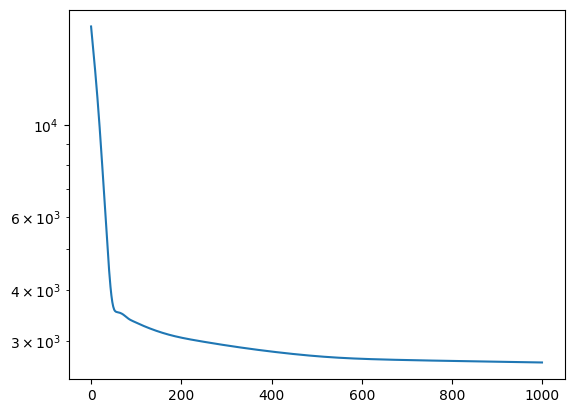

In [66]:


from torch import nn, optim

X = torch.tensor(XX[0:2,:,:], dtype=torch.float32) # 2, Np, n
Y = torch.tensor(XX[2:3,:,:], dtype=torch.float32) # 1, Np, n

# Create a simple model and optimizer
model = Model(Nm=X.shape[0], n=X.shape[2])
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
n_epochs = 1000
losses = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 100 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses.append(loss.item())

model.eval()

plt.plot(losses)
plt.yscale("log")


(1, 10000, 5)


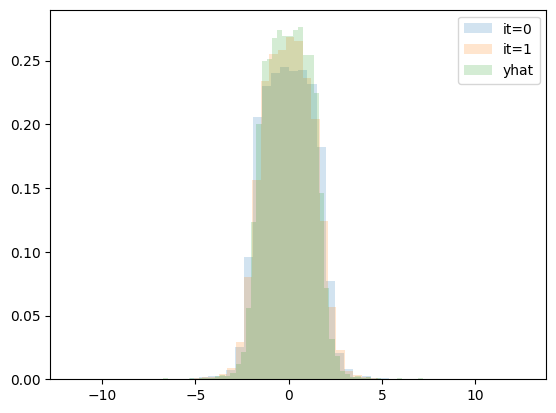

In [73]:
Yhat_OT = model.forward(X).detach().numpy()

print(Yhat_OT.shape)
plt.figure()
dim=0
[plt.hist(Xt[it,:,dim],bins=50,alpha=0.2, label="it="+str(it),density=True) for it in range(0,2)]
plt.hist(Yhat_OT[0,:,dim],bins=50,alpha=0.2,density=True, label="yhat")

plt.legend()

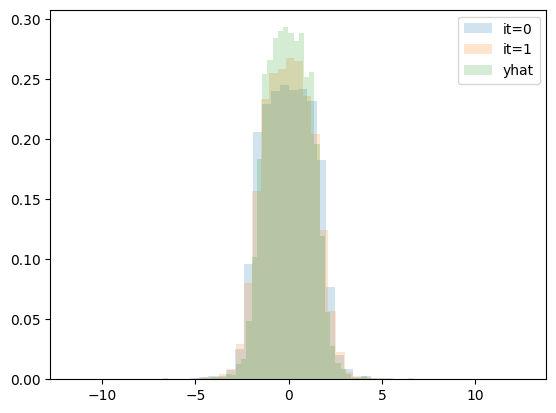

In [74]:
Y2 = np.random.normal(0,1, Xt[0:1,...].shape)

XX2 = np.concatenate([Y2, Xt[0:1,...], Xt[1:2,...]],axis=0)
X = torch.tensor(XX2[0:2,:,:], dtype=torch.float32) # 2, Np, n

Yhat_OT2 = model.forward(X).detach().numpy()

plt.figure()
dim=0
[plt.hist(Xt[it,:,dim],bins=50,alpha=0.2, label="it="+str(it),density=True) for it in range(0,2)]
plt.hist(Yhat_OT2[0,:,dim],bins=50,alpha=0.2,density=True, label="yhat")

plt.legend()


(20, 10000, 5)


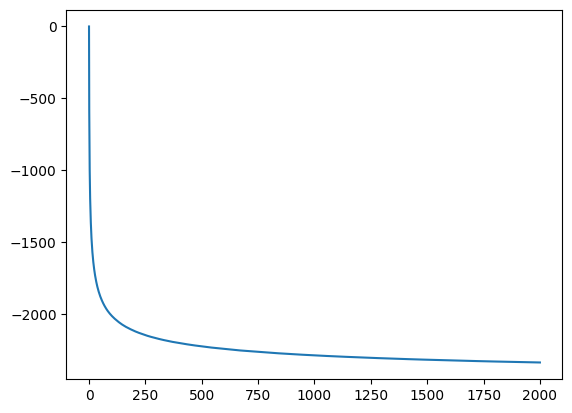

In [182]:
Xt = Xt0.copy()

from lib.collision_wrapper import find_OT_collision as newot

Xt, dists_coll = newot(Xt, MinIter=2000, MaxIter=2000, tol = 1e-9, avg_window=20, Track=0, bi=1)
#Xt, ids, dists_coll, nt, Jt = find_OT_collision_nd_nmargins_new(Xt, total_cost, change_cost, MinIter=2000, MaxIter=2000, tol = 1e-3, ISvectorized=True)

plt.plot(dists_coll)
print(Xt.shape)

# First Model

In [124]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, Nm, input_dim=1, output_dim=4, hidden_dim=200):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.Nm = Nm
        self.fc = nn.Sequential(
            nn.Linear(Nm*input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, Nm*output_dim)
        )
        #self.fc = nn.Sequential(
        #    nn.Linear(Nm*input_dim, hidden_dim),
        #    nn.Tanh(),
        #    #nn.Linear(hidden_dim, hidden_dim),
        #    #nn.Tanh(),
        #    #nn.Linear(hidden_dim, hidden_dim),
        #    #nn.Tanh(),
        #    #nn.Linear(hidden_dim, hidden_dim),
        #    #nn.Tanh(),
        #    nn.Linear(hidden_dim, Nm*input_dim)
        #)

    def forward(self, x): # x: input_dim, Np, Nm
        Np = x.shape[1]
        x = x.permute(1,0,2) # Np, input_dim, Nm
        x = x.reshape(x.shape[0],x.shape[1]*x.shape[2]) # Np, Nm*input_dim

        #t = []
        #for j in range(self.output_dim):
        #  x = x + self.fc(x)*0.1
        #  t.append(x)
        #t = torch.concatenate(t,axis=0)
        #t = t.permute(0,1)
        #t = t.reshape(self.Nm, Np, self.output_dim) # Np, Nm, output_dim*input_dim
        #return t

        x = self.fc(x) # y: Np, Nm * output_dim
        x = x.reshape(x.shape[0], self.Nm, self.output_dim) # Np, Nm, output_dim
        x = x.permute(1,0,2) # Nm, Np, output_dim
        x = x.permute(2,1,0) # output_dim, Np, Nm
        return x
    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        loss = torch.mean(torch.sum((self.forward(X) - Y) ** 2, dim=1))
        return loss


Epoch 100, Loss: 104908.9140625
Epoch 200, Loss: 74698.6875
Epoch 300, Loss: 57853.80078125
Epoch 400, Loss: 47639.51171875
Epoch 500, Loss: 42541.55859375
Epoch 600, Loss: 37594.96875
Epoch 700, Loss: 34966.98046875
Epoch 800, Loss: 31895.08984375
Epoch 900, Loss: 31813.908203125
Epoch 1000, Loss: 29395.775390625


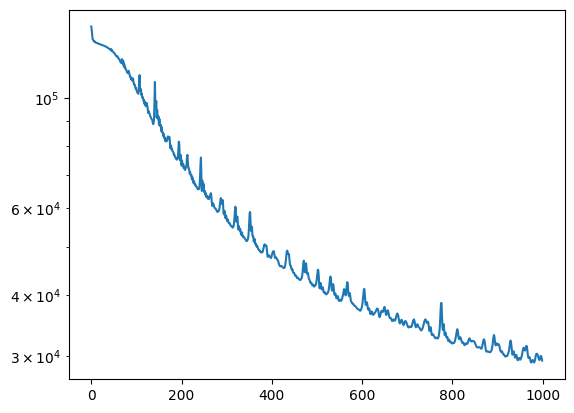

In [183]:
from torch import nn, optim

X = torch.tensor(Xt[0:1,:,:], dtype=torch.float32) # 1, Np, N
Y = torch.tensor(Xt[1:,:,:], dtype=torch.float32) #Nt-1, Np, N

# Create a simple model and optimizer
model = Model(Nm=X.shape[2], input_dim=X.shape[0], output_dim=Y.shape[0])
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Training loop
n_epochs = 1000
losses = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 100 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses.append(loss.item())

model.eval()

plt.plot(losses)
plt.yscale("log")

Epoch 100, Loss: 134735.5625
Epoch 200, Loss: 118079.6015625
Epoch 300, Loss: 103974.0625
Epoch 400, Loss: 92879.3046875
Epoch 500, Loss: 86266.734375
Epoch 600, Loss: 80321.6015625
Epoch 700, Loss: 75413.4765625
Epoch 800, Loss: 72407.125
Epoch 900, Loss: 69617.703125
Epoch 1000, Loss: 67910.8828125


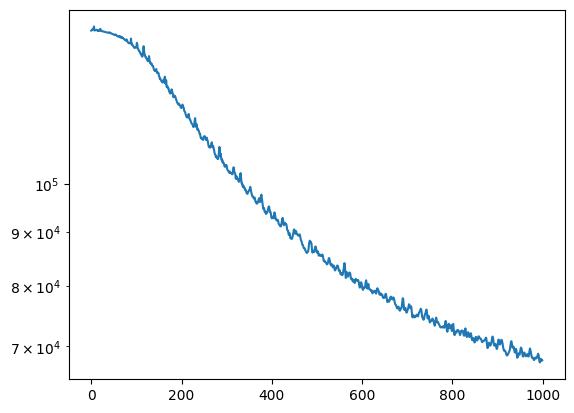

In [184]:
from torch import nn, optim

X = torch.tensor(Xt0[0:1,:,:], dtype=torch.float32) # 1, Np, N
Y = torch.tensor(Xt0[1:,:,:], dtype=torch.float32) #Nt-1, Np, N

# Create a simple model and optimizer
model_rawdata = Model(Nm=X.shape[2], input_dim=X.shape[0], output_dim=Y.shape[0])
optimizer = optim.Adam(model_rawdata.parameters(), lr=1e-2)

# Training loop
n_epochs = 1000
losses_rawdata = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model_rawdata.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 100 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses_rawdata.append(loss.item())

model_rawdata.eval()

plt.plot(losses_rawdata)
plt.yscale("log")

### Training data

In [185]:
mXt = np.mean(Xt0,axis=1) # Nt, Nm
sXt = np.var(Xt0,axis=1)**0.5 # Nt, Nm

Y = Xt0[1:,:,:]
X = torch.tensor(Xt0[0:1,:,:], dtype=torch.float32)

Yhat_OT = model.forward(X).detach().numpy()
Yhat_raw = model_rawdata.forward(X).detach().numpy()

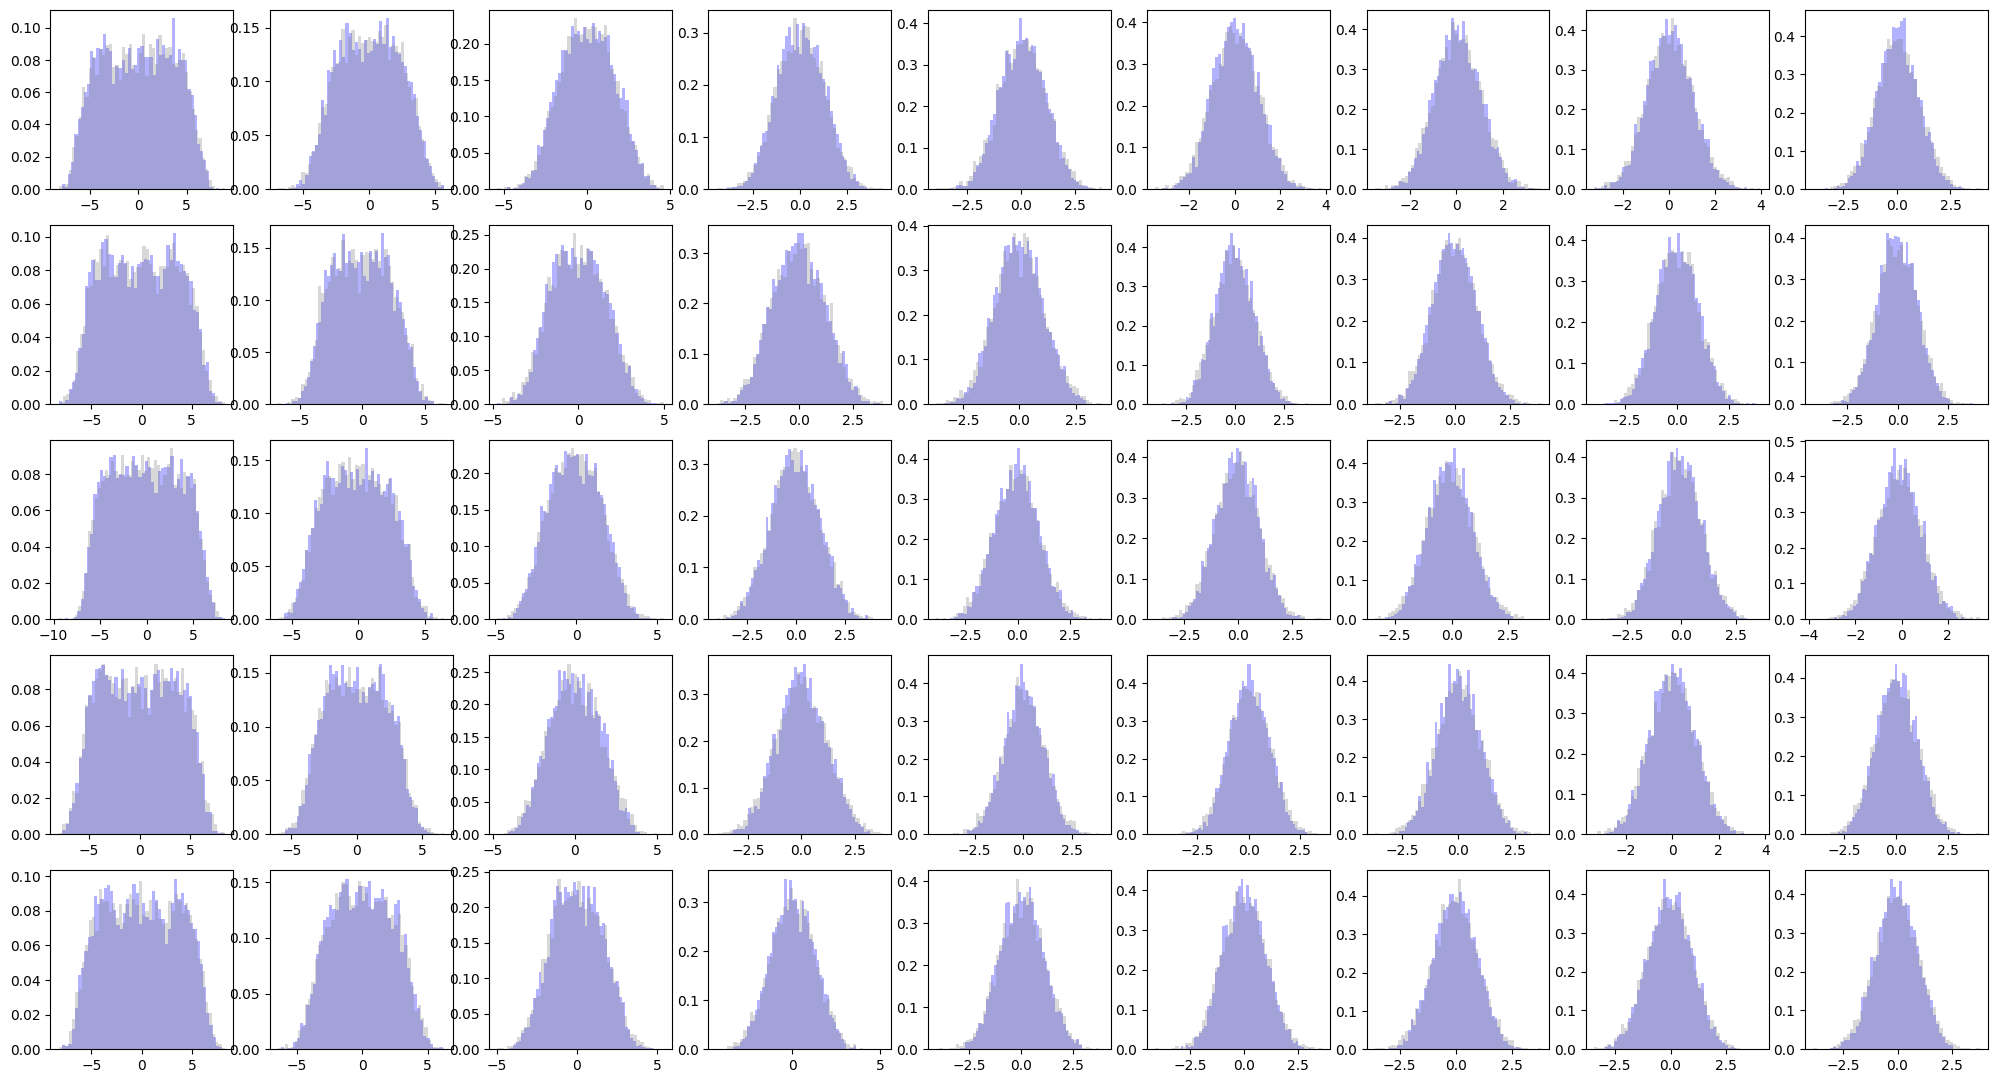

In [18]:
nout = Y.shape[2]
nX = Y.shape[0]
fig, axs = plt.subplots(nout, nX, figsize=(5*nout, 1.5*nX))
for k in range(nX):
  for j in range(nout):
    _ = axs[j,k].hist(Yhat_OT[k,:,j],bins=50,alpha=0.3,density=True, color="blue")
    _ = axs[j,k].hist(Y[k,:,j],bins=50,alpha=0.3,density=True, color="grey")


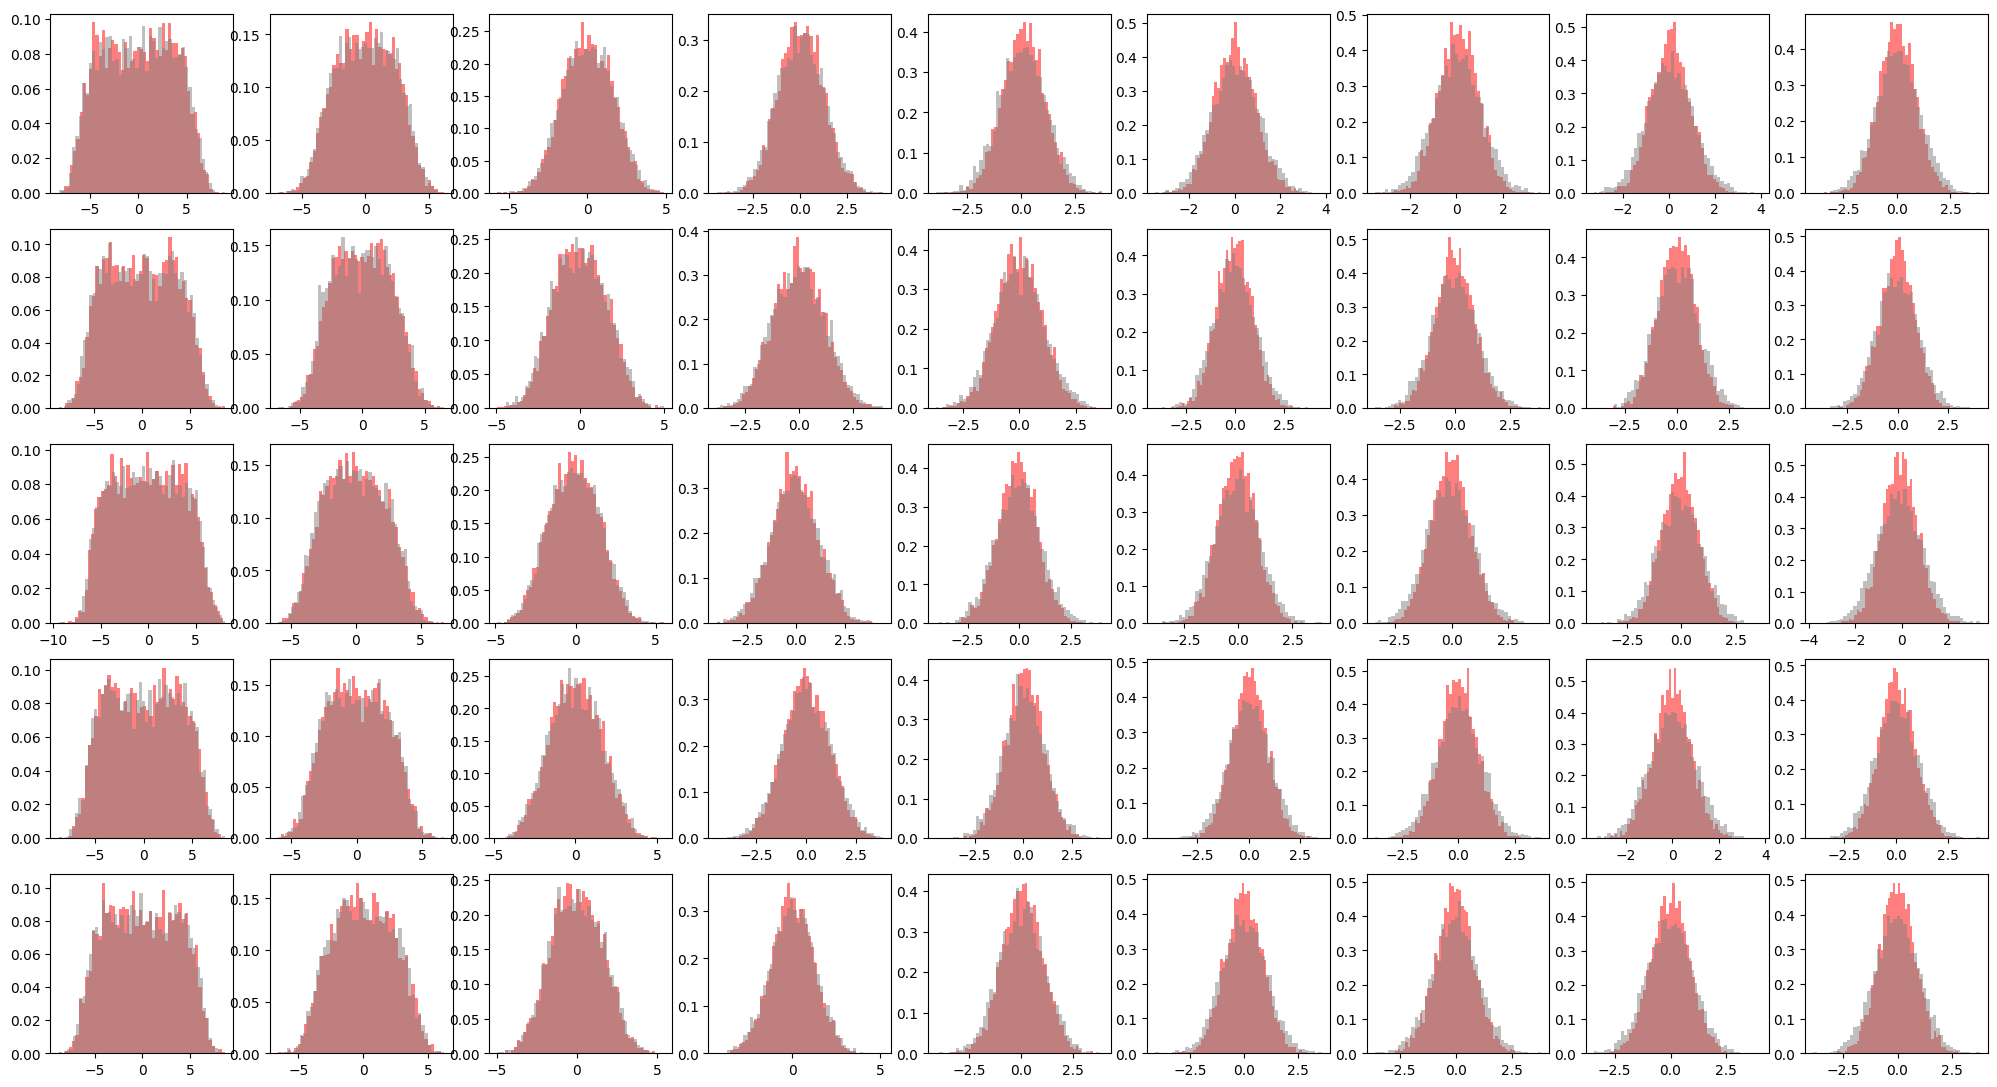

In [19]:
nout = Y.shape[2]
nX = Y.shape[0]
fig, axs = plt.subplots(nout, nX, figsize=(5*nout, 1.5*nX))
for k in range(nX):
  for j in range(nout):
    _ = axs[j,k].hist(Yhat_raw[k,:,j],bins=50,alpha=0.5,density=True, color="red")
    _ = axs[j,k].hist(Y[k,:,j],bins=50,alpha=0.5,density=True, color="grey")


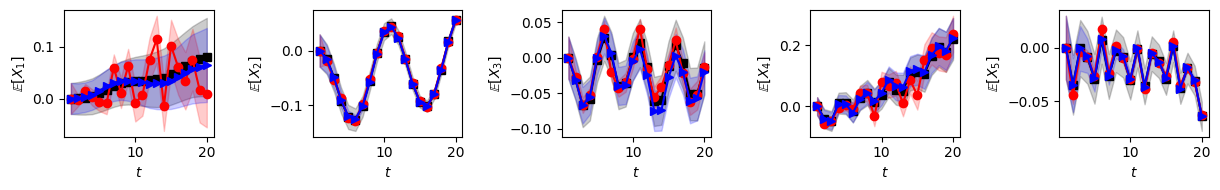

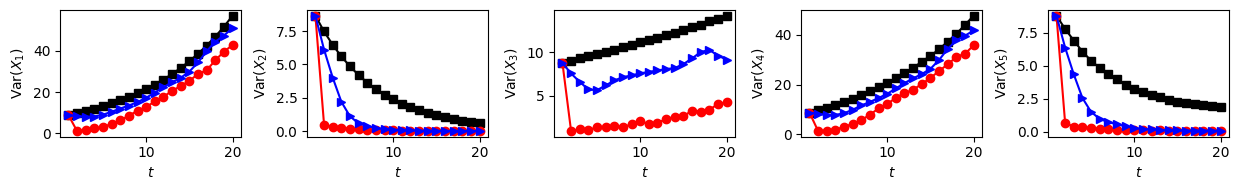

In [186]:
xx = [k+1 for k in range(Xt.shape[0])]

Yhat_full_ot = np.concatenate([Xt0[0:1,:,:], Yhat_OT], axis=0)
Yhat_full_raw = np.concatenate([Xt0[0:1,:,:], Yhat_raw], axis=0)

fig, axs = plt.subplots(1, Xt.shape[2], figsize=(2.5*Xt.shape[2], 2))
for j in range(Xt.shape[2]):
  axs[j].plot(xx, mXt[:,j], color="black", marker="s", label="Data")
  axs[j].fill_between(xx, mXt[:,j]-sXt[:,j]/100, mXt[:,j]+sXt[:,j]/100, alpha=0.2, color="black")

  m = np.mean(Yhat_full_raw[:,:,j],axis=1)
  s = np.var(Yhat_full_raw[:,:,j],axis=1)**0.5
  axs[j].plot(xx, m, color="red", marker="o", label="NN")
  axs[j].fill_between(xx, m-s/100, m+s/100, alpha=0.2, color="red")

  m = np.mean(Yhat_full_ot[:,:,j],axis=1)
  s = np.var(Yhat_full_ot[:,:,j],axis=1)**0.5
  axs[j].plot(xx, m, color="blue", marker=">", label="NN-OT")
  axs[j].fill_between(xx, m-s/100, m+s/100, alpha=0.2, color="blue")
  #axs[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=1)  # Adjust bbox_to_anchor to control position
  axs[j].set_ylabel(r"$\mathbb{E}[X_"+str(j+1)+r"]$")
  axs[j].set_xlabel(r"$t$")
plt.tight_layout()

fig, axs = plt.subplots(1, Xt.shape[2], figsize=(2.5*Xt.shape[2], 2))
for j in range(Xt.shape[2]):
  axs[j].plot(xx, sXt[:,j]**2, color="black", marker="s", label="Data")

  s = np.var(Yhat_full_raw[:,:,j],axis=1)
  axs[j].plot(xx, s, color="red", marker="o", label="NN")

  s = np.var(Yhat_full_ot[:,:,j],axis=1)
  axs[j].plot(xx, s, color="blue", marker=">", label="NN-OT")
  #axs[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=1)  # Adjust bbox_to_anchor to control position
  axs[j].set_ylabel(r"$\mathrm{Var}(X_"+str(j+1)+r")$")
  axs[j].set_xlabel(r"$t$")
plt.tight_layout()

### Testing Data

In [187]:
Nt = 200
every = 10
Xtest = generate_model(Np=Np, N=N, Nt=Nt, every=every, **variables_dict)
#Xtest += np.random.normal(0,1,Xtest.shape)

mXt = np.mean(Xtest,axis=1) # Nt, Nm
sXt = np.var(Xtest,axis=1)**0.5 # Nt, Nm

Y = Xtest[1:,:,:]
X = torch.tensor(Xtest[0:1,:,:], dtype=torch.float32)

Yhat_OT = model.forward(X).detach().numpy()
Yhat_raw = model_rawdata.forward(X).detach().numpy()

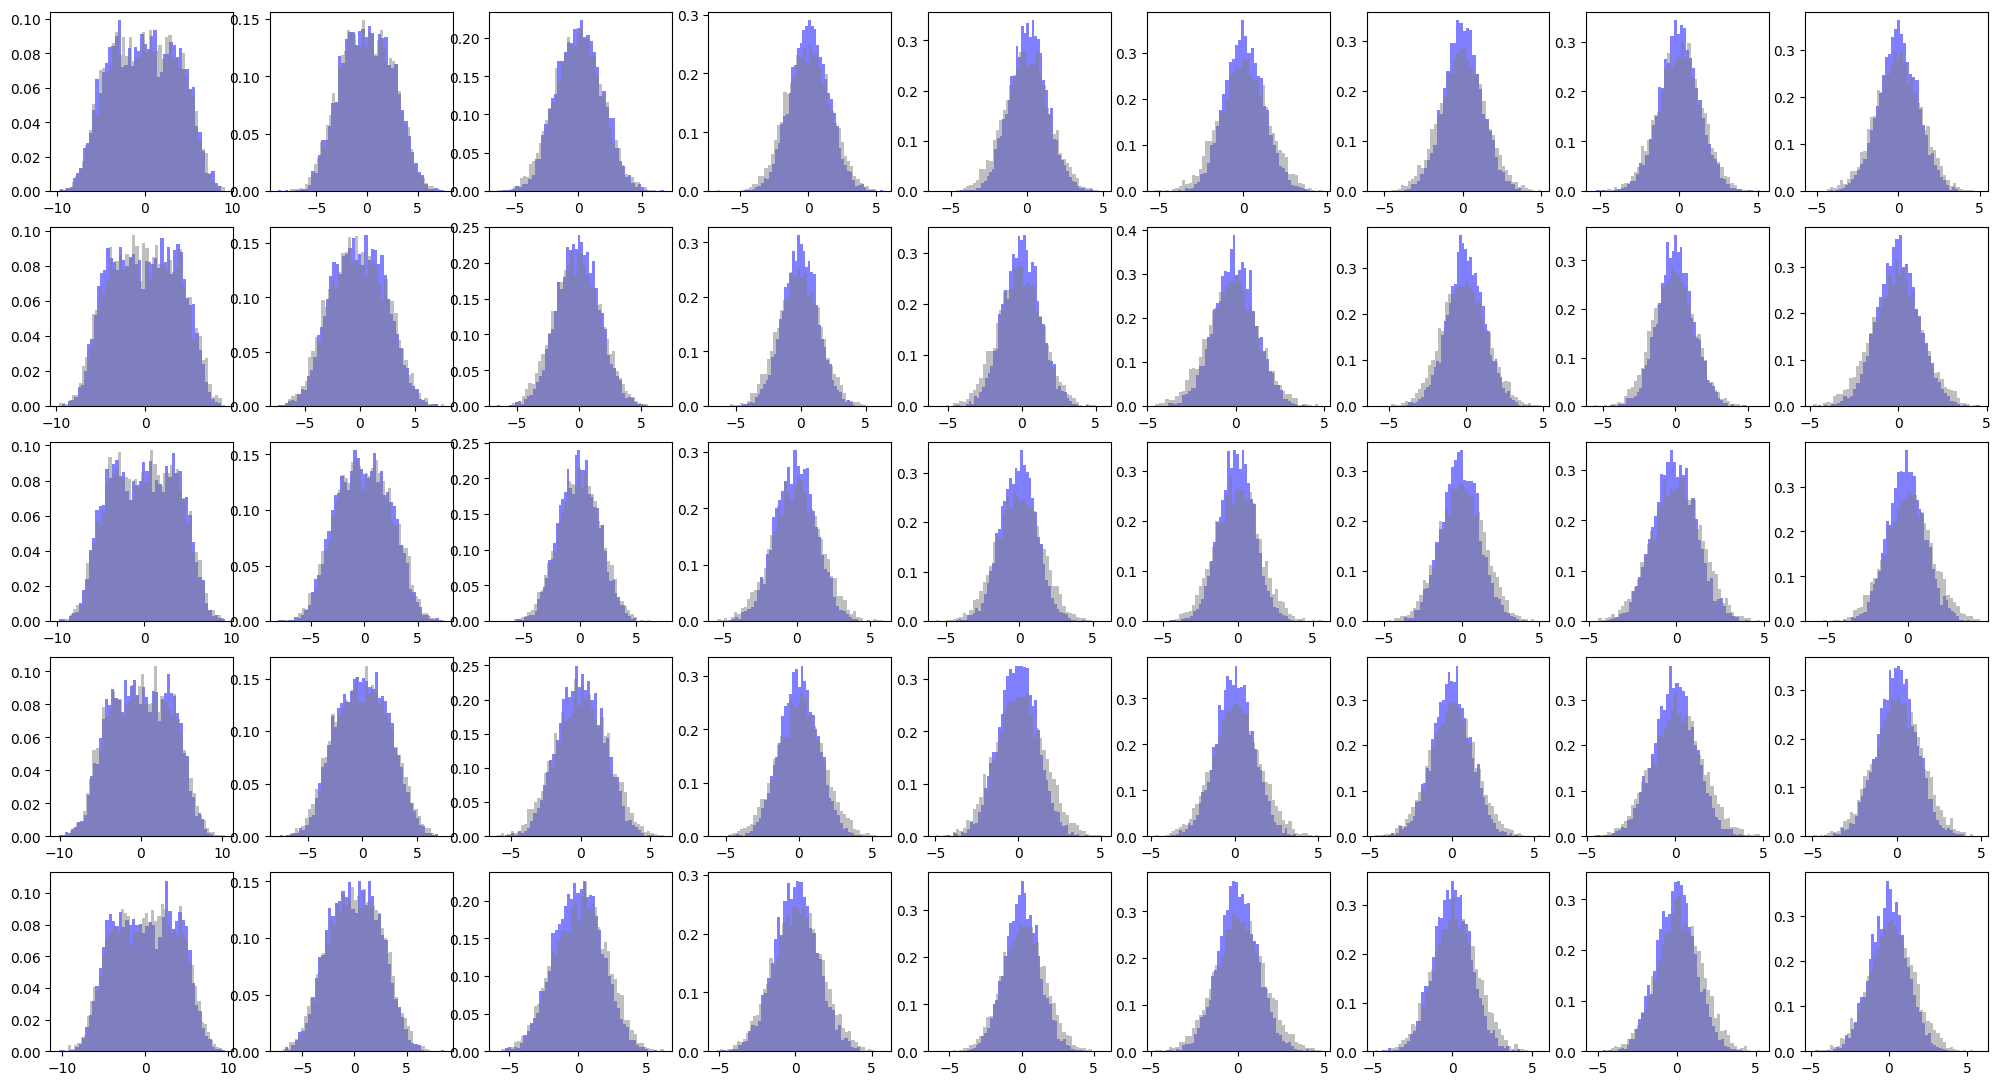

In [22]:
nout = Yhat_OT.shape[2]
nX = Yhat_OT.shape[0]
fig, axs = plt.subplots(nout, nX, figsize=(5*nout, 1.5*nX))
for k in range(nX):
  for j in range(nout):
    _ = axs[j,k].hist(Yhat_OT[k,:,j],bins=50,alpha=0.5,density=True, color="blue")
    _ = axs[j,k].hist(Y[k,:,j],bins=50,alpha=0.5,density=True, color="grey")


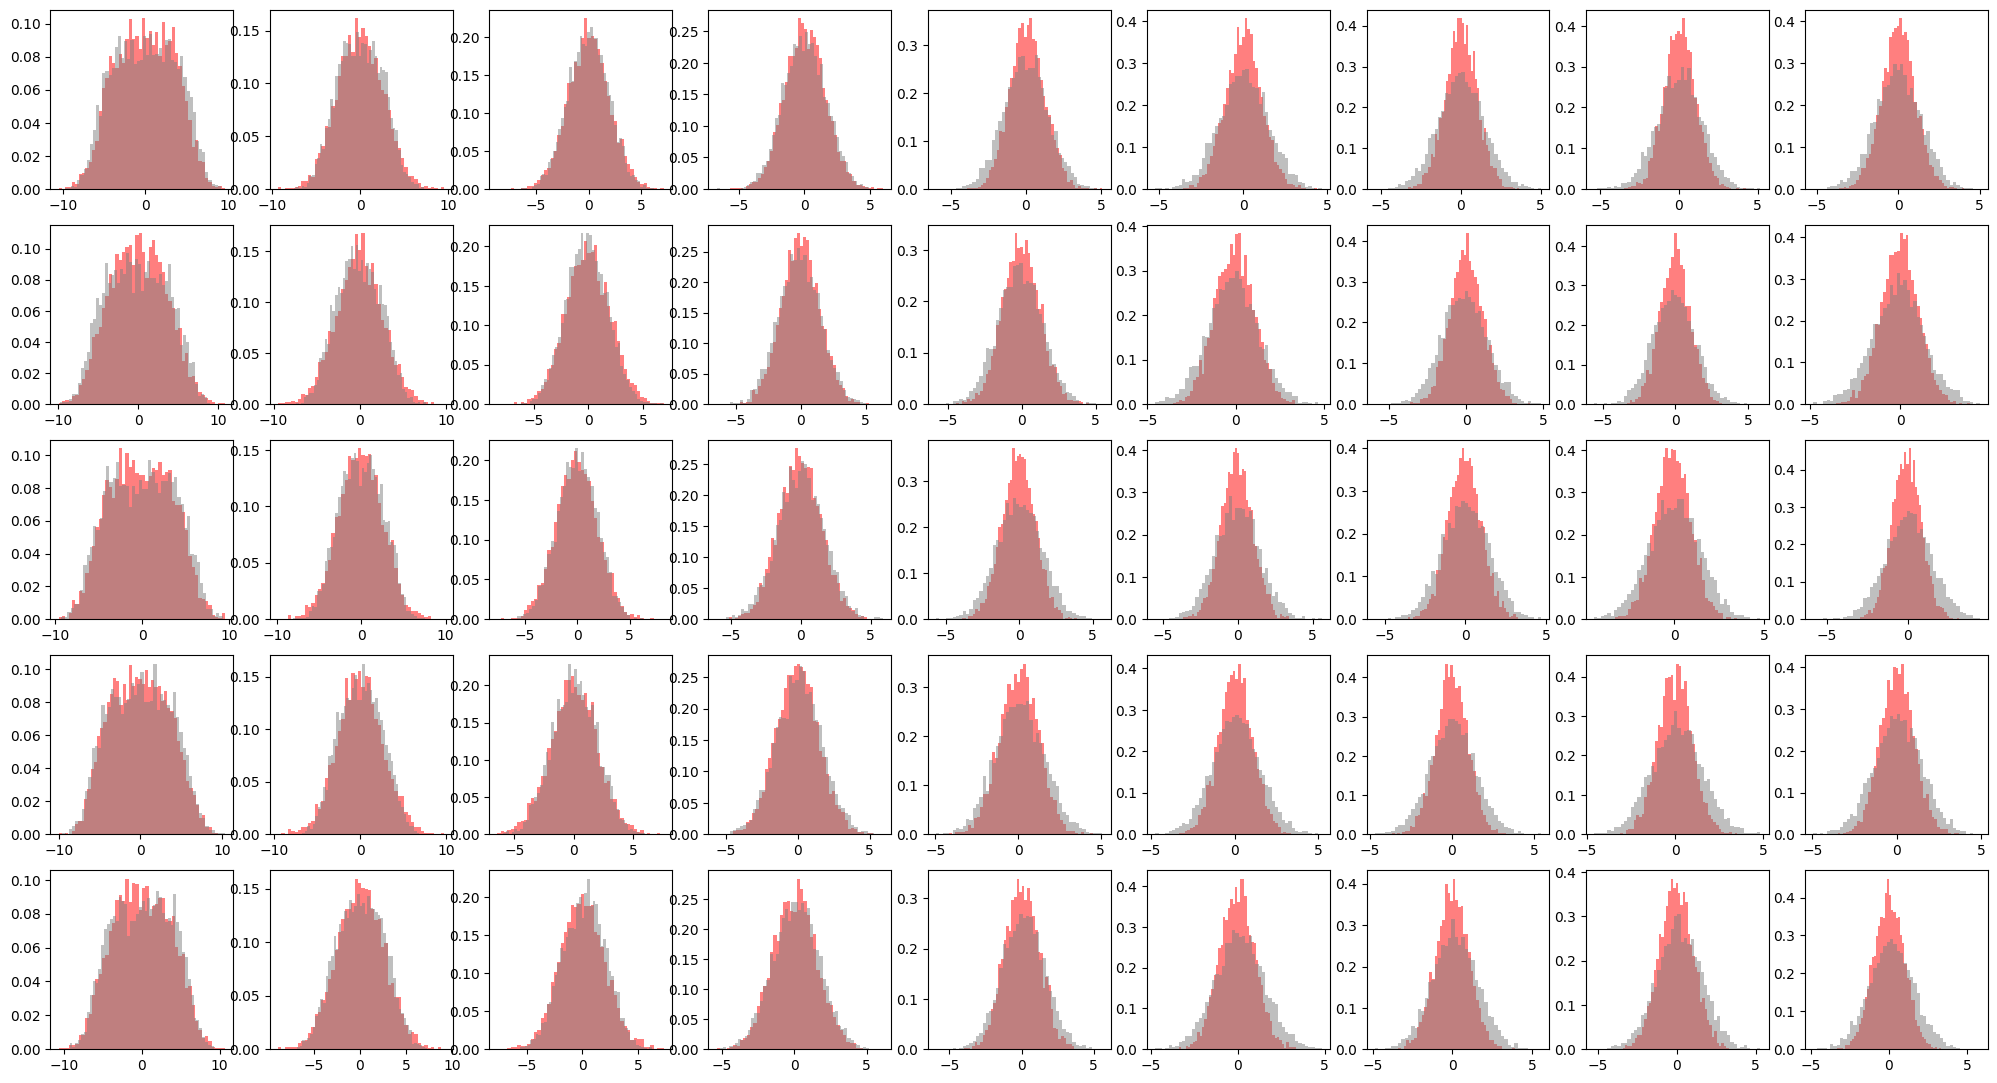

In [23]:
nout = Yhat_raw.shape[2]
nX = Yhat_raw.shape[0]
fig, axs = plt.subplots(nout, nX, figsize=(5*nout, 1.5*nX))
for k in range(nX):
  for j in range(nout):
    _ = axs[j,k].hist(Yhat_raw[k,:,j],bins=50,alpha=0.5,density=True, color="red")
    _ = axs[j,k].hist(Y[k,:,j],bins=50,alpha=0.5,density=True, color="grey")


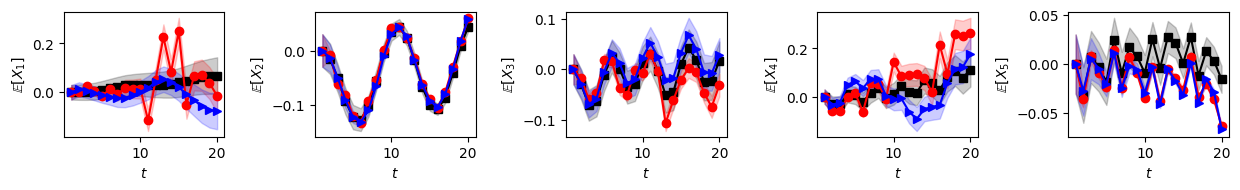

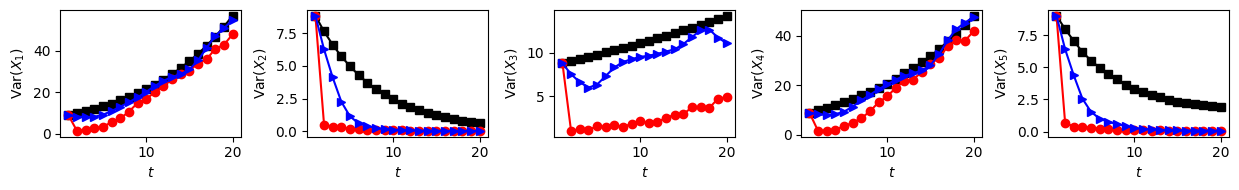

In [188]:
xx = [k+1 for k in range(Xt.shape[0])]

Yhat_full_ot = np.concatenate([Xtest[0:1,:,:], Yhat_OT], axis=0)
Yhat_full_raw = np.concatenate([Xtest[0:1,:,:], Yhat_raw], axis=0)

fig, axs = plt.subplots(1, Xt.shape[2], figsize=(2.5*Xt.shape[2], 2))
for j in range(Xt.shape[2]):
  axs[j].plot(xx, mXt[:,j], color="black", marker="s", label="Data")
  axs[j].fill_between(xx, mXt[:,j]-sXt[:,j]/100, mXt[:,j]+sXt[:,j]/100, alpha=0.2, color="black")

  m = np.mean(Yhat_full_raw[:,:,j],axis=1)
  s = np.var(Yhat_full_raw[:,:,j],axis=1)**0.5
  axs[j].plot(xx, m, color="red", marker="o", label="NN")
  axs[j].fill_between(xx, m-s/100, m+s/100, alpha=0.2, color="red")

  m = np.mean(Yhat_full_ot[:,:,j],axis=1)
  s = np.var(Yhat_full_ot[:,:,j],axis=1)**0.5
  axs[j].plot(xx, m, color="blue", marker=">", label="NN-OT")
  axs[j].fill_between(xx, m-s/100, m+s/100, alpha=0.2, color="blue")
  #axs[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=1)  # Adjust bbox_to_anchor to control position
  axs[j].set_ylabel(r"$\mathbb{E}[X_"+str(j+1)+r"]$")
  axs[j].set_xlabel(r"$t$")
plt.tight_layout()

fig, axs = plt.subplots(1, Xt.shape[2], figsize=(2.5*Xt.shape[2], 2))
for j in range(Xt.shape[2]):
  axs[j].plot(xx, sXt[:,j]**2, color="black", marker="s", label="Data")

  s = np.var(Yhat_full_raw[:,:,j],axis=1)
  axs[j].plot(xx, s, color="red", marker="o", label="NN")

  s = np.var(Yhat_full_ot[:,:,j],axis=1)
  axs[j].plot(xx, s, color="blue", marker=">", label="NN-OT")
  #axs[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=1)  # Adjust bbox_to_anchor to control position
  axs[j].set_ylabel(r"$\mathrm{Var}(X_"+str(j+1)+r")$")
  axs[j].set_xlabel(r"$t$")
plt.tight_layout()

# Second Model

In [43]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, Nt, n, hidden_dim=10):
        super(Model, self).__init__()
        self.Nt = Nt
        self.n = n
        self.fc = nn.Sequential(
            nn.Linear(Nt*n, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            #nn.Linear(hidden_dim, hidden_dim),
            #nn.Tanh(),
            nn.Linear(hidden_dim, Nt*n)
        )

    def forward(self, x): # x: Nt, Np, n
        Nt, Np, n = x.shape
        x = x.permute(1,0,2) # Np, Nt, n
        x = x.reshape(x.shape[0],x.shape[1]*x.shape[2]) # Np, Nt*n

        x = self.fc(x) # y: Np, Nt*n
        x = x.reshape(x.shape[0], self.Nt, self.n) # Np, Nt, n
        x = x.permute(1,0,2) # Nt, Np, n
        return x
    
    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        loss = torch.mean(torch.sum((self.forward(X) - Y) ** 2, dim=1))
        return loss


Epoch 100, Loss: 4063.4609375
Epoch 200, Loss: 3991.2021484375
Epoch 300, Loss: 3973.811767578125
Epoch 400, Loss: 3961.78369140625
Epoch 500, Loss: 3962.7392578125
Epoch 600, Loss: 3954.8525390625
Epoch 700, Loss: 3948.015869140625
Epoch 800, Loss: 3941.753662109375
Epoch 900, Loss: 3937.9169921875
Epoch 1000, Loss: 3934.2265625


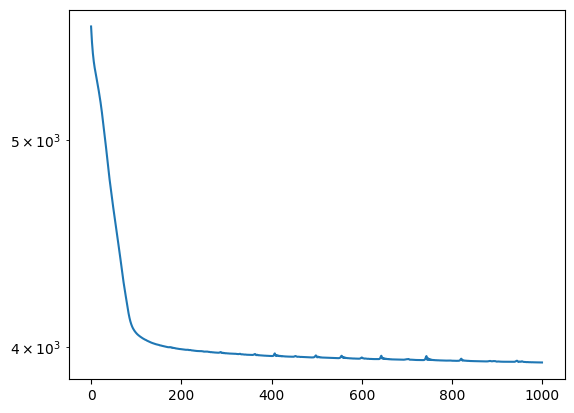

In [44]:
from torch import nn, optim

Nt = int(Xt.shape[0]/2)
X = torch.tensor(Xt[:Nt,:,:], dtype=torch.float32) # Nt, Np, n
Y = torch.tensor(Xt[Nt:,:,:], dtype=torch.float32) #Nt, Np, n

# Create a simple model and optimizer
model = Model(Nt=Nt, n=Xt.shape[2])
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# Training loop
n_epochs = 1000
losses = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 100 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses.append(loss.item())

model.eval()

plt.plot(losses)
plt.yscale("log")

Epoch 100, Loss: 5341.83544921875
Epoch 200, Loss: 5317.822265625
Epoch 300, Loss: 5299.4912109375
Epoch 400, Loss: 5284.94921875
Epoch 500, Loss: 5273.7373046875
Epoch 600, Loss: 5265.1123046875
Epoch 700, Loss: 5258.8564453125
Epoch 800, Loss: 5253.798828125
Epoch 900, Loss: 5249.806640625
Epoch 1000, Loss: 5246.89453125
Epoch 1100, Loss: 5244.5693359375
Epoch 1200, Loss: 5241.8876953125
Epoch 1300, Loss: 5240.0029296875
Epoch 1400, Loss: 5239.07958984375
Epoch 1500, Loss: 5236.955078125
Epoch 1600, Loss: 5236.3017578125
Epoch 1700, Loss: 5235.43017578125
Epoch 1800, Loss: 5234.66455078125
Epoch 1900, Loss: 5233.32861328125
Epoch 2000, Loss: 5232.60546875


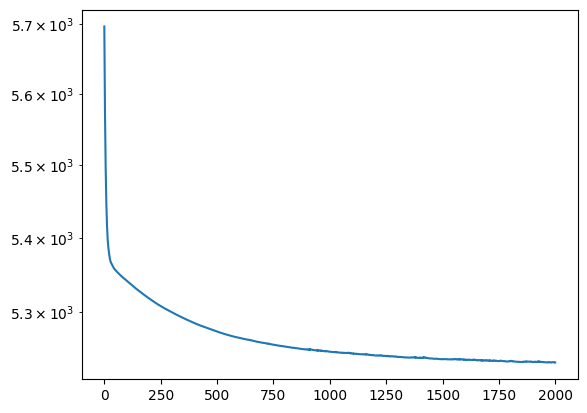

In [45]:
from torch import nn, optim

Nt = int(Xt.shape[0]/2)
X = torch.tensor(Xt0[:Nt,:,:], dtype=torch.float32) # Nt, Np, n
Y = torch.tensor(Xt0[Nt:,:,:], dtype=torch.float32) #Nt, Np, n

# Create a simple model and optimizer
model_rawdata = Model(Nt=Nt, n=Xt.shape[2])
optimizer = optim.Adam(model_rawdata.parameters(), lr=5e-3)

# Training loop
n_epochs = 2000
losses_rawdata = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model_rawdata.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 100 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses_rawdata.append(loss.item())

model_rawdata.eval()

plt.plot(losses_rawdata)
plt.yscale("log")

In [48]:
mXt = np.mean(Xt,axis=1) # Nt, Nm
sXt = np.var(Xt,axis=1)**0.5 # Nt, Nm

X = torch.tensor(Xt0[:Nt,:,:], dtype=torch.float32)

Yhat_OT = model.forward(X).detach().numpy()
Yhat_raw = model_rawdata.forward(X).detach().numpy()

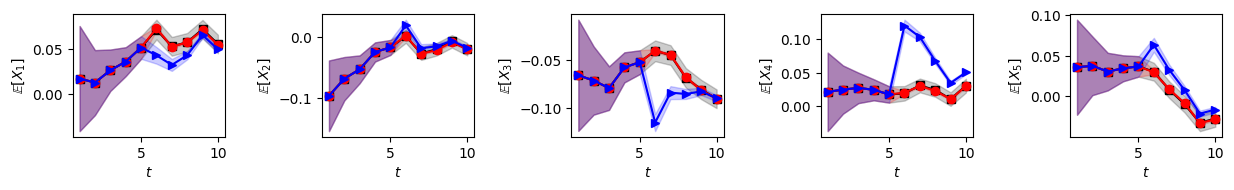

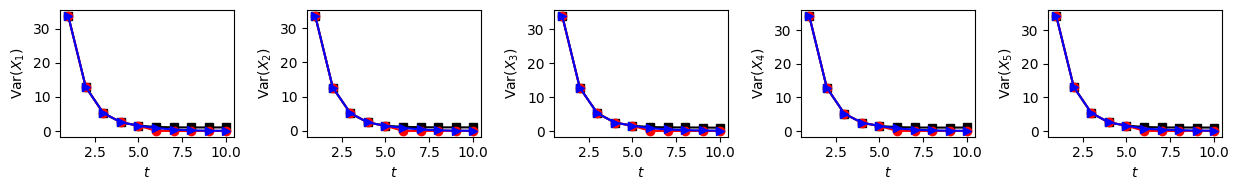

In [49]:
xx = [k+1 for k in range(Xt.shape[0])]

Yhat_full_ot = np.concatenate([Xt[0:Nt,:,:], Yhat_OT], axis=0)
Yhat_full_raw = np.concatenate([Xt[0:Nt,:,:], Yhat_raw], axis=0)

fig, axs = plt.subplots(1, Xt.shape[2], figsize=(2.5*Xt.shape[2], 2))
for j in range(Xt.shape[2]):
  axs[j].plot(xx, mXt[:,j], color="black", marker="s", label="Data")
  axs[j].fill_between(xx, mXt[:,j]-sXt[:,j]/100, mXt[:,j]+sXt[:,j]/100, alpha=0.2, color="black")

  m = np.mean(Yhat_full_raw[:,:,j],axis=1)
  s = np.var(Yhat_full_raw[:,:,j],axis=1)**0.5
  axs[j].plot(xx, m, color="red", marker="o", label="NN")
  axs[j].fill_between(xx, m-s/100, m+s/100, alpha=0.2, color="red")

  m = np.mean(Yhat_full_ot[:,:,j],axis=1)
  s = np.var(Yhat_full_ot[:,:,j],axis=1)**0.5
  axs[j].plot(xx, m, color="blue", marker=">", label="NN-OT")
  axs[j].fill_between(xx, m-s/100, m+s/100, alpha=0.2, color="blue")
  #axs[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=1)  # Adjust bbox_to_anchor to control position
  axs[j].set_ylabel(r"$\mathbb{E}[X_"+str(j+1)+r"]$")
  axs[j].set_xlabel(r"$t$")
plt.tight_layout()

fig, axs = plt.subplots(1, Xt.shape[2], figsize=(2.5*Xt.shape[2], 2))
for j in range(Xt.shape[2]):
  axs[j].plot(xx, sXt[:,j]**2, color="black", marker="s", label="Data")

  s = np.var(Yhat_full_raw[:,:,j],axis=1)
  axs[j].plot(xx, s, color="red", marker="o", label="NN")

  s = np.var(Yhat_full_ot[:,:,j],axis=1)
  axs[j].plot(xx, s, color="blue", marker=">", label="NN-OT")
  #axs[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=1)  # Adjust bbox_to_anchor to control position
  axs[j].set_ylabel(r"$\mathrm{Var}(X_"+str(j+1)+r")$")
  axs[j].set_xlabel(r"$t$")
plt.tight_layout()

# Third model

In [119]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, Nt, n, hidden_dim=100):
        super(Model, self).__init__()
        self.Nt = Nt
        self.n = n
        self.fc = nn.Sequential(
            nn.Linear(n, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            #nn.Linear(hidden_dim, hidden_dim),
            #nn.Tanh(),
            nn.Linear(hidden_dim, n)
        )

    def forward(self, x): # x: Nt, Np, n
        nt0, Np, n = x.shape
        x = x.permute(1,0,2) # Np, Nt, n
        x = x.reshape(x.shape[0],x.shape[1]*x.shape[2]) # Np, Nt*n

        xs = []
        for i in range(self.Nt):
            x = x + self.fc(x) # y: Np, n
            xs.append(x)
        xs = torch.stack(xs, dim=0)
        return xs
    
    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        loss = torch.mean(torch.sum((self.forward(X) - Y) ** 2, dim=1))
        return loss


Epoch 100, Loss: 4680.1513671875
Epoch 200, Loss: 4671.2587890625
Epoch 300, Loss: 4668.40966796875
Epoch 400, Loss: 4668.47412109375
Epoch 500, Loss: 4663.509765625
Epoch 600, Loss: 4681.19189453125
Epoch 700, Loss: 4662.87109375
Epoch 800, Loss: 4661.1748046875
Epoch 900, Loss: 4657.18310546875
Epoch 1000, Loss: 4655.9541015625


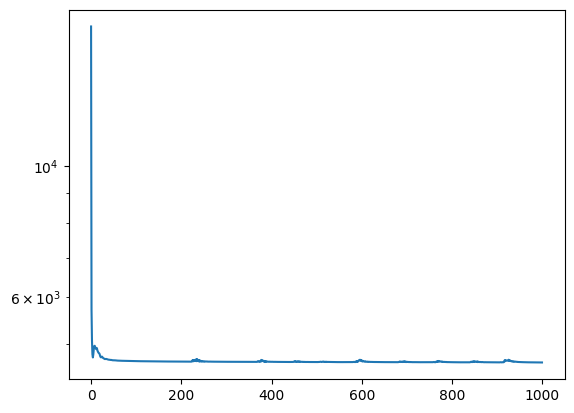

In [120]:
from torch import nn, optim

Nt = int(Xt.shape[0]-1)
X = torch.tensor(Xt[:1,:,:], dtype=torch.float32) # Nt, Np, n
Y = torch.tensor(Xt[1:,:,:], dtype=torch.float32) #Nt, Np, n

# Create a simple model and optimizer
model = Model(Nt=Nt, n=Xt.shape[2])
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# Training loop
n_epochs = 1000
losses = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 100 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses.append(loss.item())

model.eval()

plt.plot(losses)
plt.yscale("log")

Epoch 100, Loss: 5233.63134765625
Epoch 200, Loss: 5211.10107421875
Epoch 300, Loss: 5217.298828125
Epoch 400, Loss: 5203.05859375
Epoch 500, Loss: 5201.04541015625
Epoch 600, Loss: 5200.271484375
Epoch 700, Loss: 5210.50634765625
Epoch 800, Loss: 5198.40380859375
Epoch 900, Loss: 5200.92919921875
Epoch 1000, Loss: 5199.7373046875


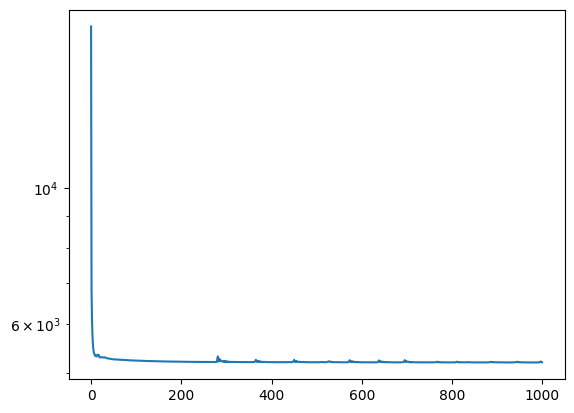

In [121]:
from torch import nn, optim

Nt = int(Xt.shape[0]-1)
X = torch.tensor(Xt0[:1,:,:], dtype=torch.float32) # Nt, Np, n
Y = torch.tensor(Xt0[1:,:,:], dtype=torch.float32) #Nt, Np, n

# Create a simple model and optimizer
model_rawdata = Model(Nt=Nt, n=Xt.shape[2])
optimizer = optim.Adam(model_rawdata.parameters(), lr=5e-3)

# Training loop
n_epochs = 1000
losses_rawdata = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model_rawdata.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 100 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses_rawdata.append(loss.item())

model_rawdata.eval()

plt.plot(losses_rawdata)
plt.yscale("log")

In [122]:
mXt = np.mean(Xt,axis=1) # Nt, Nm
sXt = np.var(Xt,axis=1)**0.5 # Nt, Nm

X = torch.tensor(Xt[:1,:,:], dtype=torch.float32)

Yhat_OT = model.forward(X).detach().numpy()
Yhat_raw = model_rawdata.forward(X).detach().numpy()

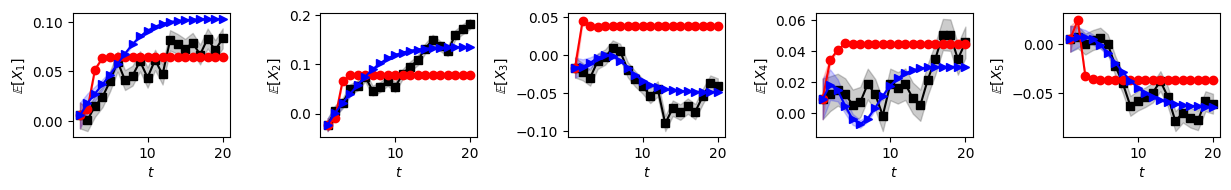

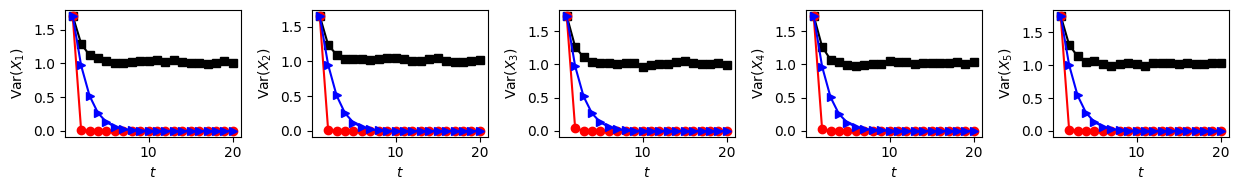

In [123]:
xx = [k+1 for k in range(Xt.shape[0])]

Yhat_full_ot = np.concatenate([Xt[0:1,:,:], Yhat_OT], axis=0)
Yhat_full_raw = np.concatenate([Xt[0:1,:,:], Yhat_raw], axis=0)

fig, axs = plt.subplots(1, Xt.shape[2], figsize=(2.5*Xt.shape[2], 2))
for j in range(Xt.shape[2]):
  axs[j].plot(xx, mXt[:,j], color="black", marker="s", label="Data")
  axs[j].fill_between(xx, mXt[:,j]-sXt[:,j]/100, mXt[:,j]+sXt[:,j]/100, alpha=0.2, color="black")

  m = np.mean(Yhat_full_raw[:,:,j],axis=1)
  s = np.var(Yhat_full_raw[:,:,j],axis=1)**0.5
  axs[j].plot(xx, m, color="red", marker="o", label="NN")
  axs[j].fill_between(xx, m-s/100, m+s/100, alpha=0.2, color="red")

  m = np.mean(Yhat_full_ot[:,:,j],axis=1)
  s = np.var(Yhat_full_ot[:,:,j],axis=1)**0.5
  axs[j].plot(xx, m, color="blue", marker=">", label="NN-OT")
  axs[j].fill_between(xx, m-s/100, m+s/100, alpha=0.2, color="blue")
  #axs[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=1)  # Adjust bbox_to_anchor to control position
  axs[j].set_ylabel(r"$\mathbb{E}[X_"+str(j+1)+r"]$")
  axs[j].set_xlabel(r"$t$")
plt.tight_layout()

fig, axs = plt.subplots(1, Xt.shape[2], figsize=(2.5*Xt.shape[2], 2))
for j in range(Xt.shape[2]):
  axs[j].plot(xx, sXt[:,j]**2, color="black", marker="s", label="Data")

  s = np.var(Yhat_full_raw[:,:,j],axis=1)
  axs[j].plot(xx, s, color="red", marker="o", label="NN")

  s = np.var(Yhat_full_ot[:,:,j],axis=1)
  axs[j].plot(xx, s, color="blue", marker=">", label="NN-OT")
  #axs[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=1)  # Adjust bbox_to_anchor to control position
  axs[j].set_ylabel(r"$\mathrm{Var}(X_"+str(j+1)+r")$")
  axs[j].set_xlabel(r"$t$")
plt.tight_layout()

In [106]:
N = 5 # number of r.v. dim(X)
Nt = 200 # number of steps, number of marginals
every = 10

Xtest = generate_model(Np=Np, N=N, Nt=Nt, every=every, **variables_dict)
Xtest += np.random.normal(0,1,Xtest.shape)

mXt = np.mean(Xtest,axis=1) # Nt, Nm
sXt = np.var(Xtest,axis=1)**0.5 # Nt, Nm

X = torch.tensor(Xtest[0:1,:,:], dtype=torch.float32)

Yhat_OT = model.forward(X).detach().numpy()
Yhat_raw = model_rawdata.forward(X).detach().numpy()

(20, 5000, 5)
(20, 5000, 5)
(20, 5)


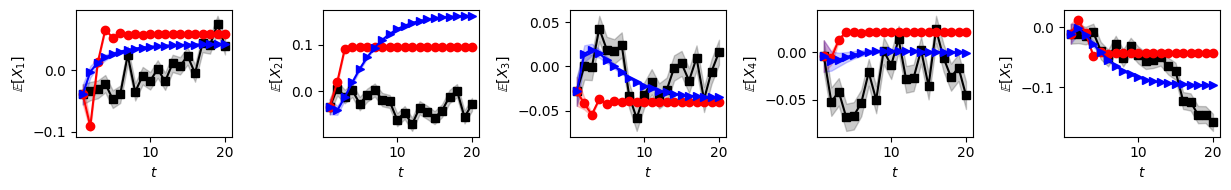

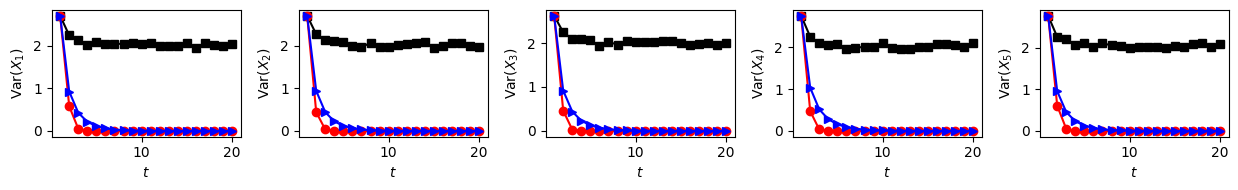

In [107]:
xx = [k+1 for k in range(Xt.shape[0])]

Yhat_full_ot = np.concatenate([Xtest[0:1,:,:], Yhat_OT], axis=0)
Yhat_full_raw = np.concatenate([Xtest[0:1,:,:], Yhat_raw], axis=0)

print(Yhat_full_ot.shape)
print(Yhat_full_raw.shape)
print(mXt.shape)
fig, axs = plt.subplots(1, Xt.shape[2], figsize=(2.5*Xt.shape[2], 2))
for j in range(Xt.shape[2]):
  axs[j].plot(xx, mXt[:,j], color="black", marker="s", label="Data")
  axs[j].fill_between(xx, mXt[:,j]-sXt[:,j]/100, mXt[:,j]+sXt[:,j]/100, alpha=0.2, color="black")

  m = np.mean(Yhat_full_raw[:,:,j],axis=1)
  s = np.var(Yhat_full_raw[:,:,j],axis=1)**0.5
  axs[j].plot(xx, m, color="red", marker="o", label="NN")
  axs[j].fill_between(xx, m-s/100, m+s/100, alpha=0.2, color="red")

  m = np.mean(Yhat_full_ot[:,:,j],axis=1)
  s = np.var(Yhat_full_ot[:,:,j],axis=1)**0.5
  axs[j].plot(xx, m, color="blue", marker=">", label="NN-OT")
  axs[j].fill_between(xx, m-s/100, m+s/100, alpha=0.2, color="blue")
  #axs[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=1)  # Adjust bbox_to_anchor to control position
  axs[j].set_ylabel(r"$\mathbb{E}[X_"+str(j+1)+r"]$")
  axs[j].set_xlabel(r"$t$")
plt.tight_layout()

fig, axs = plt.subplots(1, Xt.shape[2], figsize=(2.5*Xt.shape[2], 2))
for j in range(Xt.shape[2]):
  axs[j].plot(xx, sXt[:,j]**2, color="black", marker="s", label="Data")

  s = np.var(Yhat_full_raw[:,:,j],axis=1)
  axs[j].plot(xx, s, color="red", marker="o", label="NN")

  s = np.var(Yhat_full_ot[:,:,j],axis=1)
  axs[j].plot(xx, s, color="blue", marker=">", label="NN-OT")
  #axs[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=1)  # Adjust bbox_to_anchor to control position
  axs[j].set_ylabel(r"$\mathrm{Var}(X_"+str(j+1)+r")$")
  axs[j].set_xlabel(r"$t$")
plt.tight_layout()

In [85]:
Nt

9